# Example of DOV search methods for boreholes (boringen)

## Use cases explained below
* Get boreholes in a bounding box
* Get boreholes with specific properties
* Get boreholes in a bounding box based on specific properties
* Select boreholes in a municipality and return depth
* Get boreholes based on fields not available in the standard output dataframe
* Get borehole data, returning fields not available in the standard output dataframe
* Get boreholes in a municipality and where groundwater related data are available

In [1]:
%matplotlib inline
import inspect, sys
import warnings; warnings.simplefilter('ignore')

In [2]:
# check pydov path
import pydov

## Get information about the datatype 'Boring'

In [3]:
from pydov.search.boring import BoringSearch
boring = BoringSearch()

A description is provided for the 'Boring' datatype:

In [4]:
boring.get_description()

'In de DOV-databank is elke waarneming van grondlagen een boring. Bij de meeste boringen wordt er met een boortoestel een gat gemaakt in de ondergrond om de verschillende grondlagen te kunnen beschrijven. Aan de hand van een boring krijg je een beeld van het materiaal in de ondergrond met toenemende diepte. Afhankelijk van het doel waarvoor de boring geplaatst wordt, zal men een geschikte boormethode toepassen. Boringen worden geplaatst voor verkennend bodemonderzoek, monstername van het sediment en/of grondwater, bepaling van bodemfysische parameters, milieuhygienisch onderzoek,... Afhankelijk van de diepte, soort materiaal, en het al dan niet boren tot onder de grondwatertafel kan men kiezen uit verscheidene systemen voor handmatig of machinaal te boren. Het bodemmateriaal dat vrijkomt, kan gebruikt worden om een profiel van de ondergrond op te stellen of om er grondmonsters van te nemen om verdere analyses op uit te voeren. Vaak is het de bedoeling een put uit te bouwen zodat water 

The different fields that are available for objects of the 'Boring' datatype can be requested with the get_fields() method:

In [5]:
fields = boring.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

boorgatmeting
namen
boornummer
methode
erkenning
gecodeerde_lithologie
id
putnummer
opdrachten
boormethode
doel
uitvoerder
quartaire_stratigrafie
rapport
tertiair_onder_quartair
geotechnische_codering
diepte_methode_tot
informele_hydrostratigrafie
informele_stratigrafie
generated_id
formele_stratigrafie
pkey_boring
opdrachtgever
hydrogeologische_stratigrafie
datum_aanvang
doorheen_quartair
gemeente
start_boring_mtaw
diepte_methode_van
lithologische_beschrijving
mv_mtaw
diepte_boring_van
y
x
diepte_boring_tot
dikte_quartair


You can get more information of a field by requesting it from the fields dictionary:
* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field

In [6]:
fields['diepte_boring_tot']

{'cost': 1,
 'definition': 'Maximumdiepte van de boring ten opzichte van het aanvangspeil, in meter.',
 'name': 'diepte_boring_tot',
 'notnull': False,
 'type': 'float'}

Optionally, if the values of the field have a specific domain the possible values are listed as *values*:

In [7]:
fields['methode']['values']

['avegaarboring',
 'droge boring',
 'edelmanboring',
 'geen boring',
 'gestoken boring',
 'graafmachine',
 'handboring',
 'kernboring',
 'lansen',
 'lepelboring',
 'luchthamer',
 'luchthevelboren of air-lift boren',
 'meerdere technieken',
 'omgek. spoelboring',
 'onbekend',
 'pulsboring',
 'ramguts',
 'ramkernboring',
 'rollerbit',
 'slagboring',
 'spade',
 'spiraalboring',
 'spoelboring',
 'steenboring',
 'trilboring',
 'voorput',
 'zuigboring']

## Example use cases

### Get boreholes in a bounding box

Get data for all the boreholes that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [10]:
from pydov.util.location import Within, Box

df = boring.search(location=Within(Box(153145, 206930, 153150, 206935)))
df.head()

[000/001] .


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/1974...,GEO-74/254-b1,153147.0,206931.0,14.12,14.12,Antwerpen,0.0,14.05,1974-07-02,Rijksinstituut voor Grondmechanica,False,0.0,1.30,lepelboring
1,https://www.dov.vlaanderen.be/data/boring/1974...,GEO-74/254-b1,153147.0,206931.0,14.12,14.12,Antwerpen,0.0,14.05,1974-07-02,Rijksinstituut voor Grondmechanica,False,1.3,13.50,pulsboring
2,https://www.dov.vlaanderen.be/data/boring/1974...,GEO-74/254-b1,153147.0,206931.0,14.12,14.12,Antwerpen,0.0,14.05,1974-07-02,Rijksinstituut voor Grondmechanica,False,13.5,14.05,lepelboring


The dataframe contains one borehole where three methods ('boormethode') were applied for its construction. The available data are flattened to represent unique attributes per row of the dataframe.

Using the *pkey_boring* field one can request the details of this borehole in a webbrowser:

In [11]:
for pkey_boring in set(df.pkey_boring):
    print(pkey_boring)

https://www.dov.vlaanderen.be/data/boring/1974-010351


### Get boreholes with specific properties

Next to querying boreholes based on their geographic location within a bounding box, we can also search for boreholes matching a specific set of properties. For this we can build a query using a combination of the 'Boring' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [12]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all boreholes that are within the community (gemeente) of 'Herstappe':

In [13]:
from owslib.fes import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='gemeente',
                          literal='Herstappe')
df = boring.search(query=query)

df.head()

[000/002] ..


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/2016...,kb33d106e-B236,224687.4,158191.0,124.0,124.0,Herstappe,0.0,6.0,NaN,Belgische Geologische Dienst (BGD),False,0.0,6.0,gestoken boring
1,https://www.dov.vlaanderen.be/data/boring/1993...,kb41d120e-B1027,224820.0,157794.0,132.0,132.0,Herstappe,0.0,50.0,1993-09-02,Peeters-Ramsel,False,0.0,50.0,onbekend


Once again we can use the *pkey_boring* as a permanent link to the information of these boreholes:

In [14]:
for pkey_boring in set(df.pkey_boring):
    print(pkey_boring)

https://www.dov.vlaanderen.be/data/boring/2016-125511
https://www.dov.vlaanderen.be/data/boring/1993-096210


### Get boreholes in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the boreholes within a bounding box that have specific properties.

The following example requests the boreholes with a depth greater than or equal to 2000 meters within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [17]:
from owslib.fes import PropertyIsGreaterThanOrEqualTo

query = PropertyIsGreaterThanOrEqualTo(
            propertyname='diepte_boring_tot',
            literal='2000')

df = boring.search(
    location=Within(Box(200000, 211000, 205000, 214000)),
    query=query
    )

df.head()

[000/006] ......


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102782,201775.5,212960.0,25.0,25.0,Mol,0.0,3600.0,NaN,NaN,False,0.0,0.0,onbekend
1,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102783,201798.0,212963.0,25.0,25.0,Mol,0.0,3600.0,NaN,NaN,False,0.0,0.0,onbekend
2,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102784,201768.0,212959.0,25.0,25.0,Mol,0.0,3600.0,NaN,NaN,False,0.0,0.0,onbekend
3,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102785,201790.5,212962.0,25.0,25.0,Mol,0.0,4341.0,2016-03-02,THV Daldrup - Smet,True,0.0,4341.0,spoelboring
4,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102786,201783.0,212961.0,25.0,25.0,Mol,0.0,3610.0,2015-09-14,THV Daldrup - Smet,True,0.0,1034.0,spoelboring


We can look at one of the boreholes in a webbrowser using its *pkey_boring*:

In [18]:
for pkey_boring in set(df.pkey_boring):
    print(pkey_boring)

https://www.dov.vlaanderen.be/data/boring/2016-148765
https://www.dov.vlaanderen.be/data/boring/2016-148764
https://www.dov.vlaanderen.be/data/boring/2016-148767
https://www.dov.vlaanderen.be/data/boring/2016-148766
https://www.dov.vlaanderen.be/data/boring/2016-148770
https://www.dov.vlaanderen.be/data/boring/2016-148763


### Select boreholes in a municipality and return depth

We can limit the columns in the output dataframe by specifying the *return_fields* parameter in our search.

In this example we query all the boreholes in the city of Ghent and return their depth:

In [19]:
query = PropertyIsEqualTo(propertyname='gemeente',
                          literal='Gent')
df = boring.search(query=query,
                   return_fields=('diepte_boring_tot',))
df.head()

,diepte_boring_tot
0,42.0
1,32.0
2,59.0
3,11.0
4,27.0


In [20]:
df.describe()

,diepte_boring_tot
count,2696.000000
mean,15.474221
std,32.081506
min,0.000000
25%,0.400000
50%,6.045000
75%,20.000000
max,660.000000


By discarding the boreholes with a depth of 0 m, we get a different result:

In [21]:
df[df.diepte_boring_tot != 0].describe()

,diepte_boring_tot
count,2030.000000
mean,20.550985
std,35.534093
min,0.100000
25%,5.000000
50%,11.900000
75%,22.000000
max,660.000000


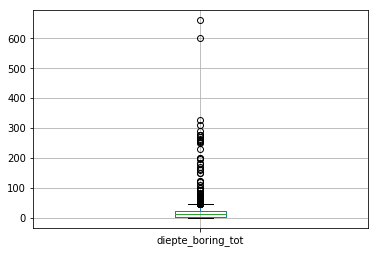

In [22]:
df[df.diepte_boring_tot != 0].boxplot()

### Get boreholes based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all availabe WFS fields are included in the standard output. However, one can use this information to select boreholes as illustrated below.

For example, make a selection of the boreholes in municipality the of Antwerp, for which a hydrogeological interpretation was performed:

In [23]:
from owslib.fes import And

query = And([PropertyIsEqualTo(propertyname='gemeente',
                               literal='Antwerpen'),
             PropertyIsEqualTo(propertyname='hydrogeologische_stratigrafie', 
                               literal='True')]
            )
df = boring.search(query=query,
                   return_fields=('pkey_boring', 'boornummer', 'x', 'y', 'diepte_boring_tot', 'datum_aanvang'))
df.head()

,pkey_boring,boornummer,x,y,diepte_boring_tot,datum_aanvang
0,https://www.dov.vlaanderen.be/data/boring/1937...,kb7d14e-B82,145457.0,224973.5,10.0,1937-01-02
1,https://www.dov.vlaanderen.be/data/boring/1969...,kb7d14e-B110,143700.4,228086.3,12.0,1969-01-01
2,https://www.dov.vlaanderen.be/data/boring/1966...,kb7d14e-B115,143067.0,227707.6,66.0,1966-01-01
3,https://www.dov.vlaanderen.be/data/boring/1966...,kb7d14e-B117,144770.5,223430.6,49.0,1966-01-01
4,https://www.dov.vlaanderen.be/data/boring/1970...,kb7d14e-B121,143597.8,223498.6,11.9,1970-01-01


### Get borehole data, returning fields not available in the standard output dataframe

As denoted in the previous example, not all available fields are available in the default output frame to keep its size limited. However, you can request any available field by including it in the *return_fields* parameter of the search:

In [24]:
query = PropertyIsGreaterThanOrEqualTo(
            propertyname='diepte_boring_tot',
            literal='2000')

df = boring.search(query=query,
                   return_fields=('pkey_boring', 'boornummer', 'diepte_boring_tot',
                                  'informele_stratigrafie', 'formele_stratigrafie', 'lithologische_beschrijving',
                                  'gecodeerde_lithologie', 'hydrogeologische_stratigrafie', 'quartaire_stratigrafie',
                                  'geotechnische_codering', 'informele_hydrostratigrafie'))

df.head()

,pkey_boring,boornummer,diepte_boring_tot,gecodeerde_lithologie,quartaire_stratigrafie,geotechnische_codering,informele_hydrostratigrafie,informele_stratigrafie,formele_stratigrafie,hydrogeologische_stratigrafie,lithologische_beschrijving
0,https://www.dov.vlaanderen.be/data/boring/1981...,kb8d7e-B224,2513.0,False,False,False,False,True,True,False,False
1,https://www.dov.vlaanderen.be/data/boring/1952...,kb8d17e-B272,2705.0,True,False,False,False,True,True,True,True
2,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102782,3600.0,False,False,False,False,False,False,False,False
3,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102783,3600.0,False,False,False,False,False,False,False,False
4,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102784,3600.0,False,False,False,False,False,False,False,False


### Get boreholes in a municipality and where groundwater related data are available

The following full example return all boreholes where *gemeente* is 'Antwerpen' and either *putnummer* is not empty or *doel* starts with 'Grondwater' or *erkenning* is '2. Andere grondwaterwinningen'.

In [25]:
from owslib.fes import PropertyIsLike
from owslib.fes import PropertyIsNull
from owslib.fes import Or
from owslib.fes import Not

query = And([PropertyIsEqualTo(propertyname='gemeente',
                               literal='Antwerpen'),
             Or([Not([PropertyIsNull(propertyname='putnummer')]),
                PropertyIsLike(propertyname='doel',
                               literal='Grondwater%'),
                PropertyIsEqualTo(propertyname='erkenning', 
                                  literal='2. Andere grondwaterwinningen')]
               )]
           )
df = boring.search(query=query)
df.head()

[000/028] ............................


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://www.dov.vlaanderen.be/data/boring/1997...,kb15d28e-B741,154825.0,212445.0,5.00,5.00,Antwerpen,0.0,36.5,1996-12-31,Meysen Dammekens (Dammekens)-Hoboken,False,0.0,36.5,onbekend
1,https://www.dov.vlaanderen.be/data/boring/1996...,kb15d43w-B393,151150.0,206550.0,18.09,18.09,Antwerpen,0.0,104.0,1996-06-26,Meysen Dammekens (Dammekens)-Hoboken,False,0.0,104.0,spoelboring
2,https://www.dov.vlaanderen.be/data/boring/2016...,B/1-102776,153099.0,213577.0,-1.00,-1.00,Antwerpen,0.0,20.0,NaN,NaN,False,0.0,0.0,onbekend
3,https://www.dov.vlaanderen.be/data/boring/2017...,1434-BG000106-9,149486.0,221697.0,5.98,5.98,Antwerpen,0.0,50.0,2017-02-09,SMET GROUP OVERSEAS,False,0.0,50.0,spoelboring
4,https://www.dov.vlaanderen.be/data/boring/2017...,B/1-102987,149408.0,224256.0,-1.00,-1.00,Antwerpen,0.0,50.0,NaN,NaN,False,0.0,0.0,onbekend


## Visualize results

Using Folium, we can display the results of our search on a map.

In [26]:
# import the necessary modules (not included in the requirements of pydov!)
import folium
from folium.plugins import MarkerCluster
from pyproj import Proj, transform

In [27]:
# convert the coordinates to lat/lon for folium
def convert_latlon(x1, y1):
    inProj = Proj(init='epsg:31370')
    outProj = Proj(init='epsg:4326')
    x2,y2 = transform(inProj, outProj, x1, y1)
    return x2, y2
df['lon'], df['lat'] = zip(*map(convert_latlon, df['x'], df['y'])) 
# convert to list
loclist = df[['lat', 'lon']].values.tolist()

In [28]:
# initialize the Folium map on the centre of the selected locations, play with the zoom until ok
fmap = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12)
marker_cluster = MarkerCluster().add_to(fmap)
for loc in range(0, len(loclist)):
    folium.Marker(loclist[loc], popup=df['boornummer'][loc]).add_to(marker_cluster)
fmap
